# Tidied up version of the predictive model

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

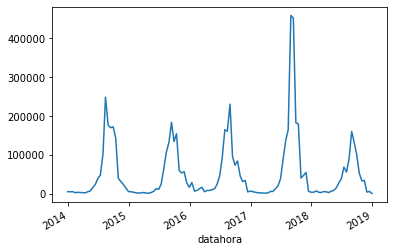

In [2]:
df2014 = pd.read_csv('../../sm-dataset/data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../sm-dataset/data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../sm-dataset/data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../sm-dataset/data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../sm-dataset/data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2014, df2015, df2016, df2017, df2018]).sort_index()

df_all = df_all.groupby(df_all.index).sum()

df_all = df_all.asfreq('SM')

df_all.riscofogo.plot()

plt.show()

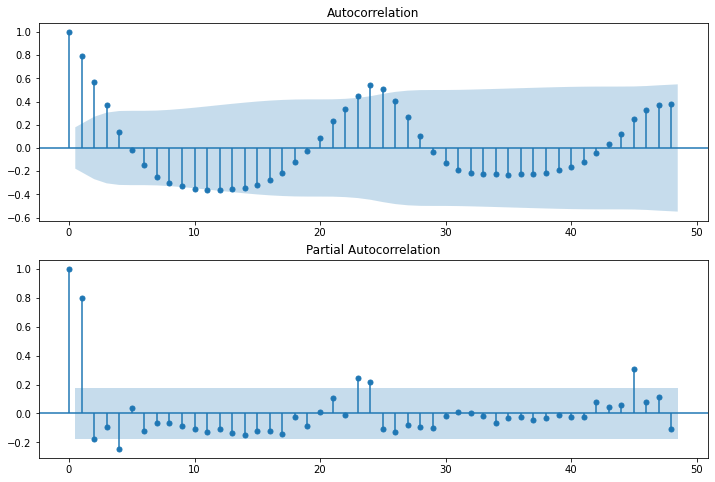

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=48,ax=ax1)
plot_pacf(df_all.dropna(),lags=48,ax=ax2)

plt.show()

#(1-4, 0, 2-3)(2-3, 0, 1, 24)

In [7]:
## Testing the stationarity

stationary_test = adfuller(df_all.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

ADF statistics : -4.836483751455998
p-value : 4.628807008490112e-05


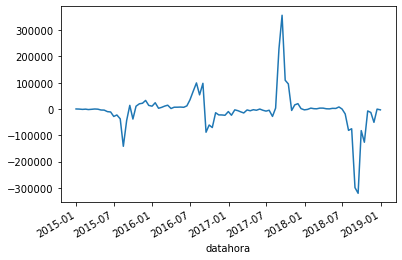

In [9]:
seasonal_diff = df_all - df_all.shift(24)

diff.riscofogo.plot()

plt.show()

In [10]:
stationary_test = adfuller(diff.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
# print('p-value : {}'.format(stationary_test[1]))

ADF statistics : -4.425308160841153
p-value : 0.000267671700767426


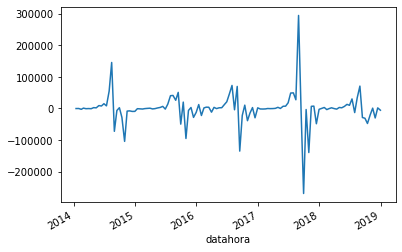

ADF statistics : -10.257408442784513
p-value : 4.324833919703425e-18


In [14]:
# biweekly difference

biweekly_diff = df_all - df_all.shift(1)

biweekly_diff.riscofogo.plot()

plt.show()
stationary_test = adfuller(biweekly_diff.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


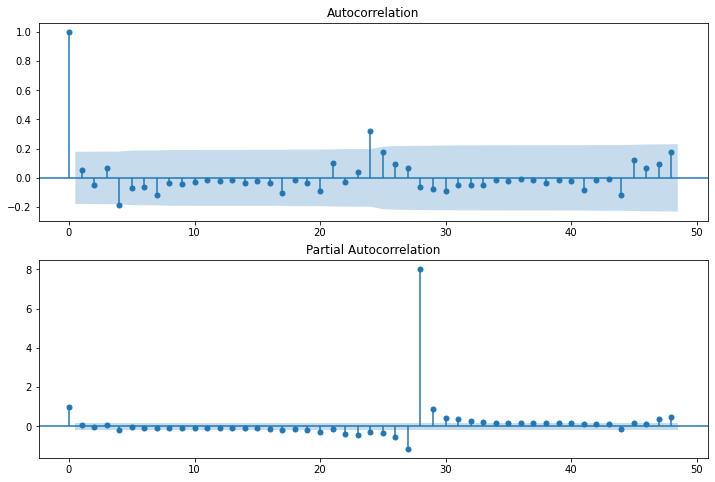

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(biweekly_diff.dropna(),lags=48,ax=ax1)
plot_pacf(biweekly_diff.dropna(),lags=48,ax=ax2)

plt.show()

We observe that the stationarity of the biweekly difference data is much more
stronger than the original or seasonal difference data. Also, there is a much
faster decay of the ACF in the biweekly data than the previous ones.

However, let's stick with the analysis of the original data and we might come
to these other differences data later.


#(1-4, 0-1, 2-3)(2-3, 0, 1, 24)
By analyzing the PACF and the ACF we get the the seasonal ARIMA parameters
$p = 1-4$, $d = 0-1$, $q = 2-3$, $P = 2$ or more, $D = 0$ and $Q = 1-2$. Let's check
which one is the best model.

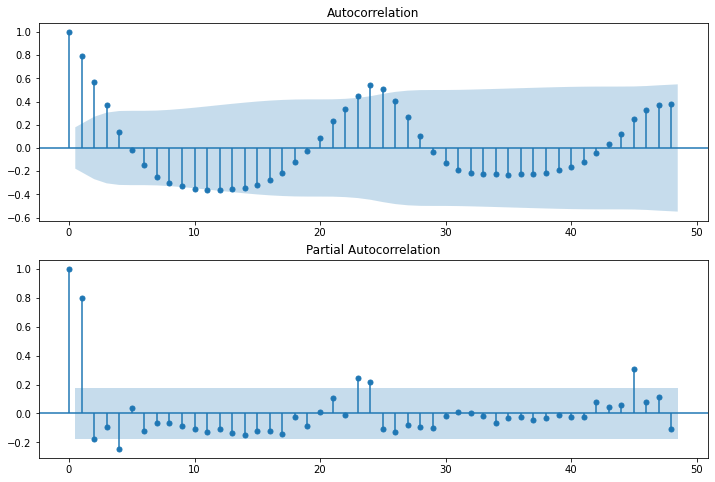

In [26]:
def model_sarima(order, sorder):
    sarima_model = sm.tsa.statespace.SARIMAX(df_all, order = order,
                                            seasonal_order = sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    res = sarima_model.fit()
    
    return order, sorder, res.aic


fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=48,ax=ax1)
plot_pacf(df_all.dropna(),lags=48,ax=ax2)

plt.show()

#(1-4, 0, 2-3)(2-3, 0, 1, 24)

In [29]:
model1 = model_sarima((4, 0, 2), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 1, 2), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 0, 3), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model1 = model_sarima((4, 1, 3), (2, 0, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) X (2, 0, 1, 24); AIC : 1703.407087424707
Model : (4, 1, 2) X (2, 0, 1, 24); AIC : 1680.0922881397005
Model : (4, 0, 3) X (2, 0, 1, 24); AIC : 1705.4367408368212
Model : (4, 1, 3) X (2, 0, 1, 24); AIC : 1681.9015211537035


In [37]:
model1 = model_sarima((1, 0, 1), (3, 1, 2, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

Model : (1, 0, 1) X (3, 1, 2, 24); AIC : 585.7126028190561


## Identifying the anomaly(ies) and handling it(them)

Since this data is seasonal, let's take a first seasonal difference

In [161]:
y_train = df_all[:len(df_all) - 24]
y_test = df_all[len(df_all) - 24:]

sarima_model = sm.tsa.statespace.SARIMAX(y_train.riscofogo, order = (1, 0, 1),
                                         seasonal_order = (3, 1, 2, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res = sarima_model.fit()
forecast = res.get_forecast(len(y_test))

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1220: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


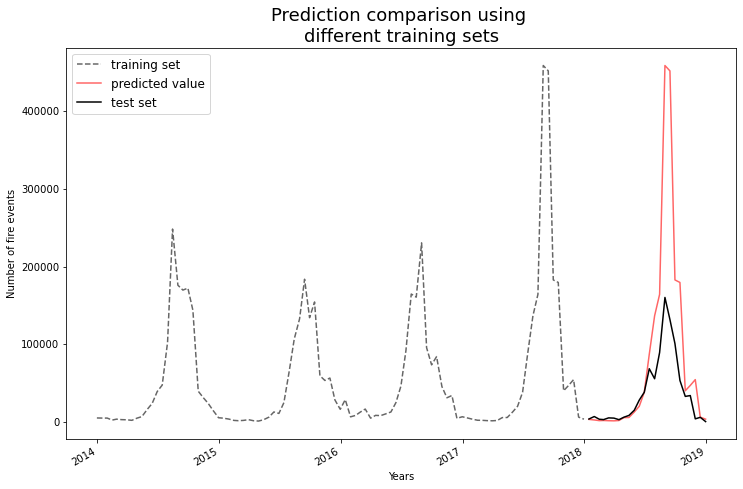

In [162]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(forecast.predicted_mean, label = 'predicted value', color = 'red', alpha = 0.6)
ax.plot(y_test.riscofogo, label = 'test set', color = 'k')

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

## Handling the anomaly in 2017 for a better prediction

### A more qualitative (pedagogical) approach

There are several ways of taking into consideration that there is an anomaly
event within the data set. One of them is to analyse the standard deviation
for a given semimonth (in this case) and analyze how it changes across years.

We might expect a pretty high value for the standard deviation within the fire period
due to the anomaly, due to its lot of variability for different years within this period.

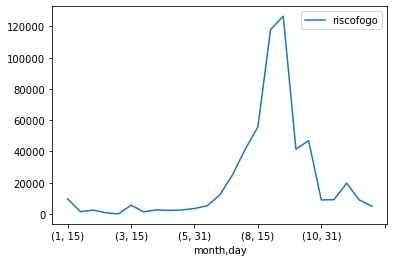

In [45]:
semimonth_deviation = df_all.groupby([df_all.index.month, df_all.index.day]).std(ddof = 0)
semimonth_deviation.index = semimonth_deviation.index.rename(names = ['month', 'day'])

semimonth_deviation.plot()
plt.show()

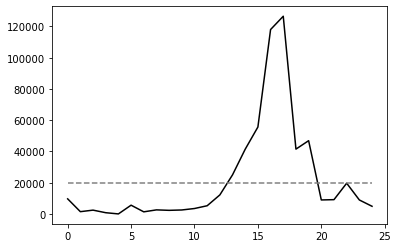

In [46]:
## The anomaly indeed show up within the higher number of fire events, as expected

## Let's set a threshold for this anomaly events

threshold = 20000*np.ones(len(semimonth_deviation))

fig, ax = plt.subplots()

ax.plot(np.array(semimonth_deviation), color = 'k')
ax.plot(threshold, linestyle = '--', c = 'grey')
plt.show()

In [47]:
## Identifying the anomaly period in a table

anomaly_region = semimonth_deviation[semimonth_deviation > 20000].copy().dropna()
anomaly_region

riscofogo
month day               
7     15    25013.565627
      31    41424.733660
8     15    55615.093338
      31   118016.817848
9     15   126522.940504
      30    41472.064060
10    15    46876.899307

## A more quantitative approach

In [48]:
## seasonal trend decomposition 

stl = STL(df_all, period = 24) ## Since we have semimonth data
decomposition = stl.fit()

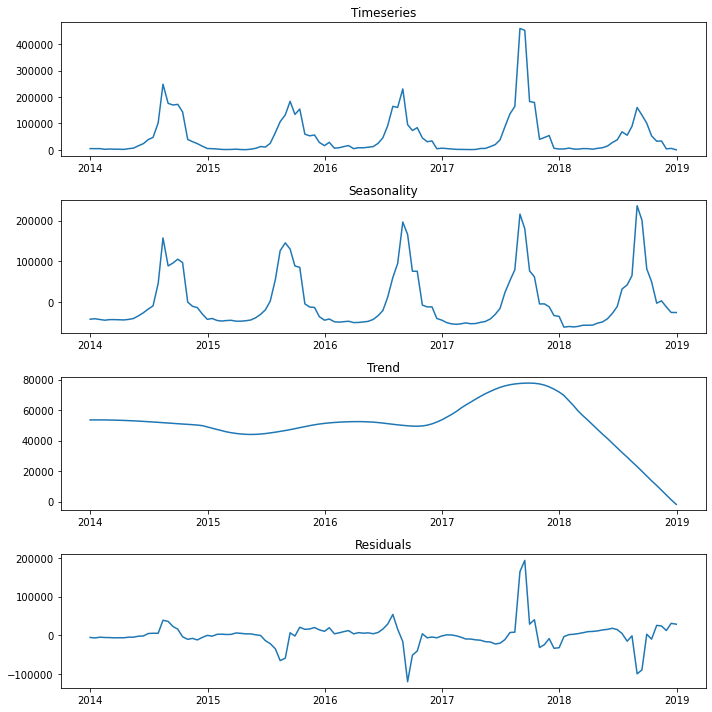

In [49]:
seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all)
ax1.set_title('Timeseries')
ax2.plot(seasonal)
ax2.set_title('Seasonality')
ax3.plot(trend)
ax3.set_title('Trend')
ax4.plot(residuals)
ax4.set_title('Residuals')


plt.tight_layout()
plt.show()

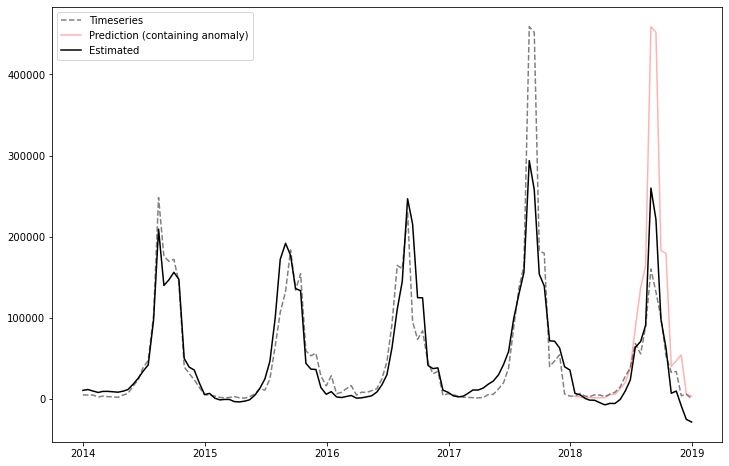

In [50]:
## Getting the difference due to the residuals

plt.figure(figsize = (12,8))
plt.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
plt.plot(forecast.predicted_mean, label = 'Prediction (containing anomaly)', color = 'red', alpha = 0.3)
plt.plot(seasonal+trend, label = "Estimated", c = 'k')
plt.legend()
plt.show()

## Brief discussion about the above result

By the result above, we observe that the difference between the estimated curve and
the real timeseries is entirely due to the residuals. What is left for us is to decide
whether these residuals are anomalies or not. For example, for sure in 2017 there is an
anomaly event, as discussed previously. Now what we want is to analyze other mismatches,
for example, like the one in 2014. *Is that an anomaly as well?* To  do so, we need to quantify
it better. Let's then analyze the residuals in greater detail

In [51]:
# Working with  the residuals

residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Getting the lower and upper values of it

lower = residuals_mean - 3*residuals_std
upper = residuals_mean + 3*residuals_std

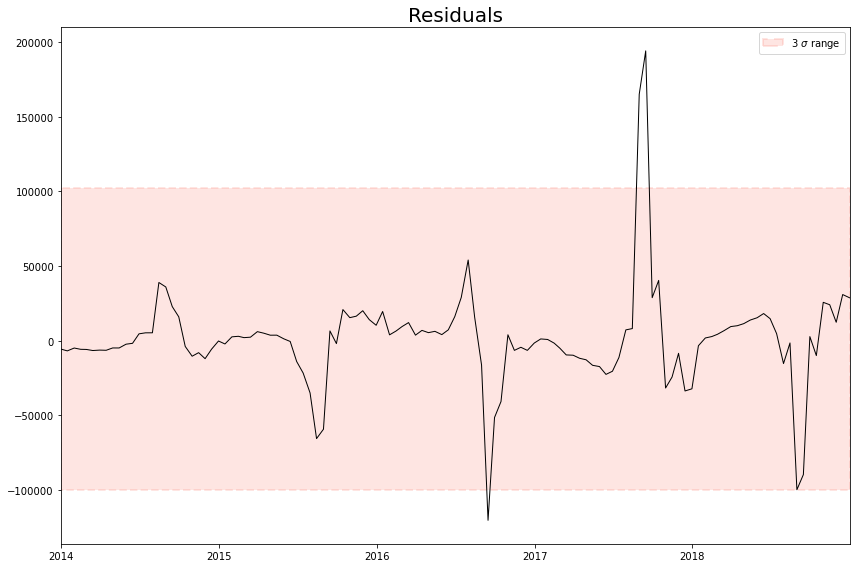

In [52]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(residuals, color = 'k', linewidth = 1)

ax.fill_between([df_all.index[0], df_all.index[-1]], lower, upper,
                label = '3 $\sigma$ range',
                color = 'salmon', alpha = 0.2,
                linestyle = '--', linewidth = 2)

ax.set_xlim(df_all.index[0], df_all.index[-1])

ax.set_title('Residuals', fontsize = 20)

plt.legend()
plt.tight_layout()
plt.show()

In [53]:
## And we observe that accordingly, we have two points almost a third one
## which can be considered  as anomalies. Lets show them on the original plot

anomaly_dates = df_all[(residuals > upper) | (residuals < lower)]

anomaly_dates

## Ah okay, the point in 2018 is not an anomaly per se, but within the peak of 2017
## there are two points (end Augst and beginning of September)

,riscofogo
datahora,
2016-09-15,95478.0
2017-08-31,458846.0
2017-09-15,451911.0


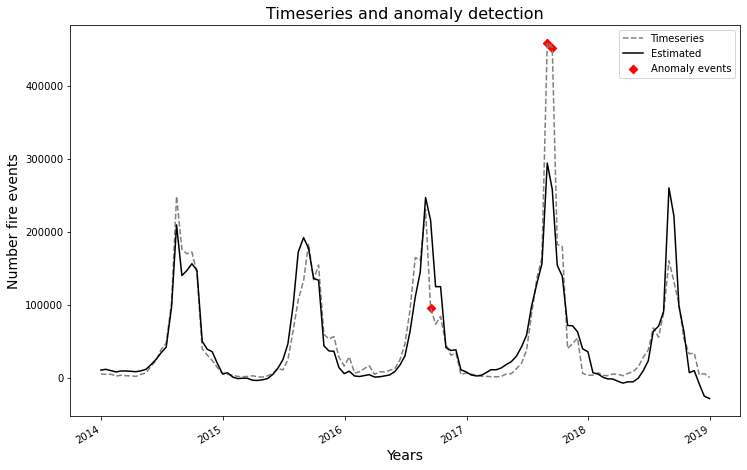

In [54]:
## Plotting the points above

fig, ax = plt.subplots(figsize = (12,8))


ax.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
ax.plot(seasonal+trend, label = "Estimated", c = 'k')
ax.scatter(anomaly_dates.index, anomaly_dates.riscofogo, color='r', marker='D', label = 'Anomaly events')

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number fire events', fontsize = 14)

ax.set_title('Timeseries and anomaly detection', fontsize = 16)

plt.gcf().autofmt_xdate()
plt.legend()

plt.show()

Understanding it better, if we google it "fire events Brazil 2017" We find a bunch of news
saying that brazil got a record in the number of fire events since 1999! For those interestered
might wanna check [this](https://imazon.org.br/imprensa/brasil-termina-2017-com-numero-recorde-de-queimadas-desde-1999/) or [this one](https://g1.globo.com/natureza/noticia/brasil-tem-ano-com-o-maior-numero-de-queimadas-da-historia.ghtml).

It is also quite sad, because by what we have investigated so far we know that 2019 was
also a record and 2020 broke it again. So, within the near future these events which were
anomaly so far might not be anymore and may be the new reality of our biomes.

Now let's get back and include the fact that these peaks were indeed anomalies and make
a new prediction for 2018. *Okay, but how to do so?* The idea is simple: since we have
already identified the anomalies we are going to built a new dataset where the anomalies
are replaced by the mean value of the regular data (at the same date, of course). We then are going
to use these new data, where the anomaly is corrected, to make a new model for the prediction
in 2018.

In [55]:
df_all_ac = df_all.copy() #ac stands for anomaly corrected
y_train_ac = y_train.copy()

for date in anomaly_dates.index:
    condition = (y_train_ac.index.day == date.day) & (y_train_ac.index.month == date.month) & (y_train_ac.index.year != date.year)
    corrected_value = y_train_ac[condition].mean() # take the mean for of previous years
    y_train_ac.loc[date].iat[0] = corrected_value            # change the anomaly event

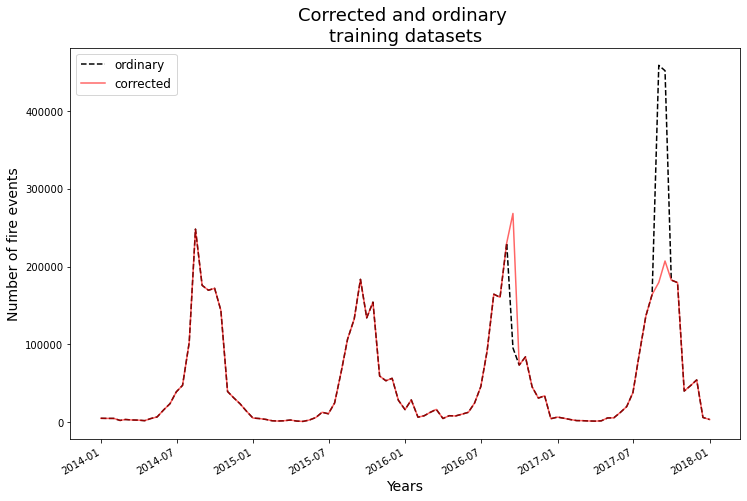

In [56]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(y_train, linestyle = '--', color = 'k', label = 'ordinary')
ax.plot(y_train_ac, color = 'red', label = 'corrected', alpha = 0.6)

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_title('Corrected and ordinary \ntraining datasets', fontsize = 18)

plt.gcf().autofmt_xdate()
plt.legend(fontsize = 12)

plt.show()

## Summing up and next steps

Now we have corrected the anomaly effect in a new dataset and we are going to use it to predict
2018 events. For doing so, let's follow similar steps to those ones at the beginning and get the
best model

ADF statistics : -5.091595439391679
p-value : 1.4574902158878894e-05


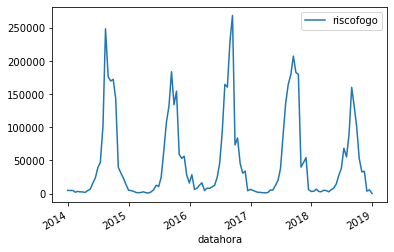

In [58]:
df_all_ac = pd.concat([y_train_ac, y_test])

stationary_test = adfuller(df_all_ac.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

df_all_ac.plot()
plt.show()

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


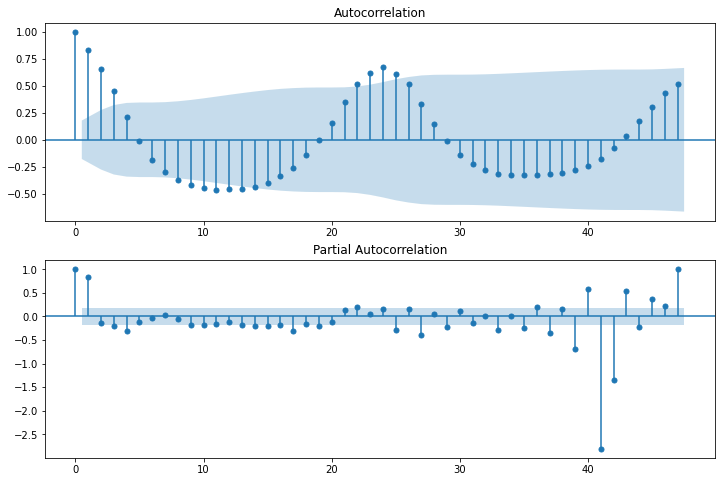

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax1)
plot_pacf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax2)

plt.show()

By analyzing the PACF and the ACF we get the the seasonal ARIMA parameters
$p = 1-3$, $d = 0$, $q = 1-3$, $P = 2$ or more, $D = 1$ and $Q = 1$. Let's check
which one is the best model.

In [61]:
model1 = model_sarima((1, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 1), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 1) X (2, 1, 1, 24); AIC : 1183.9940512549326
Model : (2, 0, 1) X (2, 1, 1, 24); AIC : 1161.5349818229406
Model : (3, 0, 1) X (2, 1, 1, 24); AIC : 1139.5691662501767


In [62]:
model1 = model_sarima((1, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 2), (2, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 2) X (2, 1, 1, 24); AIC : 1186.2507826199153
Model : (2, 0, 2) X (2, 1, 1, 24); AIC : 1161.455295248669


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) X (2, 1, 1, 24); AIC : 1141.51003511138


In [63]:
model1 = model_sarima((1, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, 2), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 2) X (3, 1, 1, 24); AIC : 586.6488925638929
Model : (2, 0, 2) X (3, 1, 1, 24); AIC : 564.7706960105323


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) X (3, 1, 1, 24); AIC : 542.6191119392586


In [75]:
model1 = model((1, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model((2, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model((3, 0, 3), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, 3) X (3, 1, 1, 24); AIC : 588.7604043404951
Model : (2, 0, 3) X (3, 1, 1, 24); AIC : 20.0
Model : (3, 0, 3) X (3, 1, 1, 24); AIC : 544.2834071358575


In [65]:
model1 = model_sarima((1, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

model2 = model_sarima((2, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model2[0], model2[1], model2[2]))

model3 = model_sarima((3, 0, (1, 0, 1)), (3, 1, 1, 24))
print('Model : {} X {}; AIC : {}'.format(model3[0], model3[1], model3[2]))

Model : (1, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 587.3130351677412
Model : (2, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 565.5311913975586
Model : (3, 0, (1, 0, 1)) X (3, 1, 1, 24); AIC : 543.9552670332112


## Prediction using the above method and the new training data

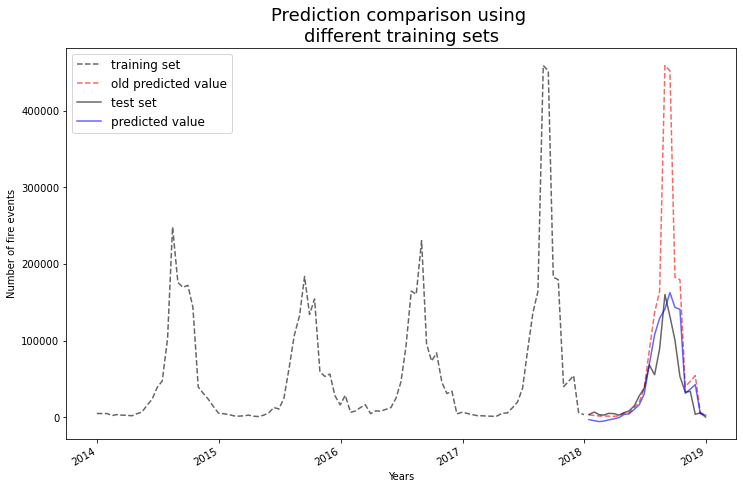

In [98]:
y_train_ac = df_all_ac[:len(df_all) - 24]
y_test_ac = df_all_ac[len(df_all) - 24:]

#diff = df_all_ac - df_all_ac.shift(24)

sarima_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = (4, 0, 3),
                                         seasonal_order = (1, 0, 0, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res_ac = sarima_model_ac.fit()
forecast_ac = res_ac.get_forecast(len(y_test))


fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(forecast.predicted_mean, label = 'old predicted value', color = 'red', alpha = 0.6, linestyle = '--')
ax.plot(y_test.riscofogo, label = 'test set', color = 'k', alpha = 0.6)

ax.plot(forecast_ac.predicted_mean, label = 'predicted value', color = 'blue', alpha = 0.6)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

In [95]:
residuals = forecast.predicted_mean - y_test.riscofogo
residuals_new = forecast_ac.predicted_mean - y_test.riscofogo

MAE = np.mean(abs(residuals/y_test.riscofogo))
MAE_new = np.mean(abs(residuals_new/y_test.riscofogo))

print ('Mean absolute error: {}'.format(round(MAE, 2)))
print ('Mean absolute error: {}'.format(round(MAE_new, 2)))

Mean absolute error: 1.62
Mean absolute error: 1.47


In [96]:
rmse = np.sqrt(mean_squared_error(forecast_ac.predicted_mean, y_test))


print(rmse)
print(y_test.riscofogo.mean())

42908.907746483404
35812.791666666664


# Random tests 

In [83]:
p = range(1,5)
d = range(0,2)
q = range(1,4)

P = range(0,4)
D = range(0,2)
Q = range(0,2)

pdq = list(itertools.product(p, d, q))        ## pdq values
pdqs = [(P, D, Q, 24) for P, D, Q in itertools.product(P, D, Q)]      ## pdq values for the seasonal part

In [79]:
## Investigating different models

model_dict = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        res = sarimax.fit()
        forecast = res.get_forecast(len(y_test))
        
        
        residuals = forecast.predicted_mean - y_test.riscofogo
        MAE = np.mean(abs(residuals/y_test.riscofogo))
        
        model_dict[(param, seasonal_param)] = MAE
        
        print ('Model : {} x {}; MAE in percentage : {}'.format(param, seasonal_param, MAE))
        

Model : (1, 0, 1) x (0, 0, 0, 24); MAE in percentage : 0.7808562628885168
Model : (1, 0, 1) x (0, 0, 1, 24); MAE in percentage : 1.2785879708529884
Model : (1, 0, 1) x (0, 1, 0, 24); MAE in percentage : 1.4572203420359326


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 1) x (0, 1, 1, 24); MAE in percentage : 1.4523322151292772
Model : (1, 0, 1) x (1, 0, 0, 24); MAE in percentage : 1.2492419821507244
Model : (1, 0, 1) x (1, 0, 1, 24); MAE in percentage : 2.2356864756399335
Model : (1, 0, 1) x (1, 1, 0, 24); MAE in percentage : 1.7063020289948099
Model : (1, 0, 1) x (1, 1, 1, 24); MAE in percentage : 1.7684290531725742
Model : (1, 0, 1) x (2, 0, 0, 24); MAE in percentage : 1.881102252504269
Model : (1, 0, 1) x (2, 0, 1, 24); MAE in percentage : 2.5049258762387265
Model : (1, 0, 1) x (2, 1, 0, 24); MAE in percentage : 2.3193743415378263
Model : (1, 0, 1) x (2, 1, 1, 24); MAE in percentage : 2.575610444995459
Model : (1, 0, 1) x (3, 0, 0, 24); MAE in percentage : 2.7405265449912313
Model : (1, 0, 1) x (3, 0, 1, 24); MAE in percentage : 2.6831334146810484


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1220: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


Model : (1, 0, 1) x (3, 1, 0, 24); MAE in percentage : 1.9520727104592215
Model : (1, 0, 1) x (3, 1, 1, 24); MAE in percentage : 1.9520727104592208
Model : (1, 0, 2) x (0, 0, 0, 24); MAE in percentage : 1.2785461693638192
Model : (1, 0, 2) x (0, 0, 1, 24); MAE in percentage : 1.15556754959622
Model : (1, 0, 2) x (0, 1, 0, 24); MAE in percentage : 1.4388307069184394


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 2) x (0, 1, 1, 24); MAE in percentage : 1.4567041848764581
Model : (1, 0, 2) x (1, 0, 0, 24); MAE in percentage : 1.0521901461364356
Model : (1, 0, 2) x (1, 0, 1, 24); MAE in percentage : 3.1149941622217745
Model : (1, 0, 2) x (1, 1, 0, 24); MAE in percentage : 1.7227498338737846
Model : (1, 0, 2) x (1, 1, 1, 24); MAE in percentage : 1.7764705773073093
Model : (1, 0, 2) x (2, 0, 0, 24); MAE in percentage : 2.0030592482167227
Model : (1, 0, 2) x (2, 0, 1, 24); MAE in percentage : 2.6316202862551745
Model : (1, 0, 2) x (2, 1, 0, 24); MAE in percentage : 2.0883209838031553


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 2) x (2, 1, 1, 24); MAE in percentage : 2.381659814255022
Model : (1, 0, 2) x (3, 0, 0, 24); MAE in percentage : 2.7663338318993715
Model : (1, 0, 2) x (3, 0, 1, 24); MAE in percentage : 2.988343250933719
Model : (1, 0, 2) x (3, 1, 0, 24); MAE in percentage : 1.967140761514295
Model : (1, 0, 2) x (3, 1, 1, 24); MAE in percentage : 1.9671407615142946
Model : (1, 0, 3) x (0, 0, 0, 24); MAE in percentage : 1.0933538821800437
Model : (1, 0, 3) x (0, 0, 1, 24); MAE in percentage : 1.4171708179130913
Model : (1, 0, 3) x (0, 1, 0, 24); MAE in percentage : 1.4723174024467032


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (0, 1, 1, 24); MAE in percentage : 1.8514278047983506
Model : (1, 0, 3) x (1, 0, 0, 24); MAE in percentage : 1.2225123892907652
Model : (1, 0, 3) x (1, 0, 1, 24); MAE in percentage : 2.250524507419041
Model : (1, 0, 3) x (1, 1, 0, 24); MAE in percentage : 1.7640069834599184
Model : (1, 0, 3) x (1, 1, 1, 24); MAE in percentage : 1.8513653546792008
Model : (1, 0, 3) x (2, 0, 0, 24); MAE in percentage : 1.9768249772634168
Model : (1, 0, 3) x (2, 0, 1, 24); MAE in percentage : 2.662633429369506
Model : (1, 0, 3) x (2, 1, 0, 24); MAE in percentage : 2.340910295786053


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 1, 1, 24); MAE in percentage : 2.4057366842806656
Model : (1, 0, 3) x (3, 0, 0, 24); MAE in percentage : 2.756720462566445
Model : (1, 0, 3) x (3, 0, 1, 24); MAE in percentage : 2.9300608673846207
Model : (1, 0, 3) x (3, 1, 0, 24); MAE in percentage : 2.0386654729460125
Model : (1, 0, 3) x (3, 1, 1, 24); MAE in percentage : 2.0386654729460116
Model : (1, 1, 1) x (0, 0, 0, 24); MAE in percentage : 4.205359204019865
Model : (1, 1, 1) x (0, 0, 1, 24); MAE in percentage : 358417.0617553833
Model : (1, 1, 1) x (0, 1, 0, 24); MAE in percentage : 1.5862525478371448


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (1, 1, 1) x (0, 1, 1, 24); MAE in percentage : 6.394530178455175
Model : (1, 1, 1) x (1, 0, 0, 24); MAE in percentage : 5.423527297489481
Model : (1, 1, 1) x (1, 0, 1, 24); MAE in percentage : 8.683500199688773e+25
Model : (1, 1, 1) x (1, 1, 0, 24); MAE in percentage : 3.6992894603290387
Model : (1, 1, 1) x (1, 1, 1, 24); MAE in percentage : 5.316272469037544
Model : (1, 1, 1) x (2, 0, 0, 24); MAE in percentage : 3.5811297902607797


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 1) x (2, 0, 1, 24); MAE in percentage : 9.754067968495388e+27
Model : (1, 1, 1) x (2, 1, 0, 24); MAE in percentage : 1.4770110561831515
Model : (1, 1, 1) x (2, 1, 1, 24); MAE in percentage : 1.4555890265095683
Model : (1, 1, 1) x (3, 0, 0, 24); MAE in percentage : 2.332451677491314


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 1) x (3, 0, 1, 24); MAE in percentage : 6.107217287420574e+25
Model : (1, 1, 1) x (3, 1, 0, 24); MAE in percentage : 1.279589467391248
Model : (1, 1, 1) x (3, 1, 1, 24); MAE in percentage : 1.279589467391248
Model : (1, 1, 2) x (0, 0, 0, 24); MAE in percentage : 3.2227000578835554


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (0, 0, 1, 24); MAE in percentage : 10451582657.795706
Model : (1, 1, 2) x (0, 1, 0, 24); MAE in percentage : 3.463652456281737
Model : (1, 1, 2) x (0, 1, 1, 24); MAE in percentage : 5.287001217638871
Model : (1, 1, 2) x (1, 0, 0, 24); MAE in percentage : 3.6911347837932595
Model : (1, 1, 2) x (1, 0, 1, 24); MAE in percentage : 1756595254.460069
Model : (1, 1, 2) x (1, 1, 0, 24); MAE in percentage : 3.8257543831941483
Model : (1, 1, 2) x (1, 1, 1, 24); MAE in percentage : 4.800431679424325
Model : (1, 1, 2) x (2, 0, 0, 24); MAE in percentage : 3.419672356130093


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (2, 0, 1, 24); MAE in percentage : 2.685437249950232


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 2) x (2, 1, 0, 24); MAE in percentage : 2.74793304552951
Model : (1, 1, 2) x (2, 1, 1, 24); MAE in percentage : 2.5939187175765195
Model : (1, 1, 2) x (3, 0, 0, 24); MAE in percentage : 2.5838082676474423
Model : (1, 1, 2) x (3, 0, 1, 24); MAE in percentage : 2.206719026348428
Model : (1, 1, 2) x (3, 1, 0, 24); MAE in percentage : 2.4494894223554167
Model : (1, 1, 2) x (3, 1, 1, 24); MAE in percentage : 2.4494894223554167
Model : (1, 1, 3) x (0, 0, 0, 24); MAE in percentage : 0.9563872867309681


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (0, 0, 1, 24); MAE in percentage : 2138869676.0448885
Model : (1, 1, 3) x (0, 1, 0, 24); MAE in percentage : 3.472608069254863
Model : (1, 1, 3) x (0, 1, 1, 24); MAE in percentage : 5.366736429497942
Model : (1, 1, 3) x (1, 0, 0, 24); MAE in percentage : 3.7510147496641397


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (1, 0, 1, 24); MAE in percentage : 19997464797.595585
Model : (1, 1, 3) x (1, 1, 0, 24); MAE in percentage : 3.6850503572221505
Model : (1, 1, 3) x (1, 1, 1, 24); MAE in percentage : 4.978839034766307
Model : (1, 1, 3) x (2, 0, 0, 24); MAE in percentage : 3.3675960361490915


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (2, 0, 1, 24); MAE in percentage : 2.157978395533316
Model : (1, 1, 3) x (2, 1, 0, 24); MAE in percentage : 2.645357613554537


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) x (2, 1, 1, 24); MAE in percentage : 1.2500974027235232
Model : (1, 1, 3) x (3, 0, 0, 24); MAE in percentage : 2.2263466926281694
Model : (1, 1, 3) x (3, 0, 1, 24); MAE in percentage : 2.014530172372011
Model : (1, 1, 3) x (3, 1, 0, 24); MAE in percentage : 3.6440083662828173
Model : (1, 1, 3) x (3, 1, 1, 24); MAE in percentage : 3.6440083662828173
Model : (2, 0, 1) x (0, 0, 0, 24); MAE in percentage : 4.1840268022424665
Model : (2, 0, 1) x (0, 0, 1, 24); MAE in percentage : 8.111484117502629
Model : (2, 0, 1) x (0, 1, 0, 24); MAE in percentage : 1.45681196312501


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (0, 1, 1, 24); MAE in percentage : 3.301669228589734e+32
Model : (2, 0, 1) x (1, 0, 0, 24); MAE in percentage : 5.018862102325854
Model : (2, 0, 1) x (1, 0, 1, 24); MAE in percentage : 3.5115370462820734
Model : (2, 0, 1) x (1, 1, 0, 24); MAE in percentage : 1.765910650668672
Model : (2, 0, 1) x (1, 1, 1, 24); MAE in percentage : 1.7961971689219656
Model : (2, 0, 1) x (2, 0, 0, 24); MAE in percentage : 2.0858975009213823
Model : (2, 0, 1) x (2, 0, 1, 24); MAE in percentage : 2.906468214942359
Model : (2, 0, 1) x (2, 1, 0, 24); MAE in percentage : 2.0987181573370743


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 1, 1, 24); MAE in percentage : 2.518926832842066
Model : (2, 0, 1) x (3, 0, 0, 24); MAE in percentage : 2.7951161343217095


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (3, 0, 1, 24); MAE in percentage : 4.6714423176166235
Model : (2, 0, 1) x (3, 1, 0, 24); MAE in percentage : 3615229.37726262
Model : (2, 0, 1) x (3, 1, 1, 24); MAE in percentage : 3615229.3772625527
Model : (2, 0, 2) x (0, 0, 0, 24); MAE in percentage : 1.600584916464573
Model : (2, 0, 2) x (0, 0, 1, 24); MAE in percentage : 1.9085594950160267
Model : (2, 0, 2) x (0, 1, 0, 24); MAE in percentage : 1.435780287731407


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (0, 1, 1, 24); MAE in percentage : 1.5580915084210767
Model : (2, 0, 2) x (1, 0, 0, 24); MAE in percentage : 4.949306078434191
Model : (2, 0, 2) x (1, 0, 1, 24); MAE in percentage : 3.0116721172499226
Model : (2, 0, 2) x (1, 1, 0, 24); MAE in percentage : 2.935599985168715
Model : (2, 0, 2) x (1, 1, 1, 24); MAE in percentage : 3.5430773824302277
Model : (2, 0, 2) x (2, 0, 0, 24); MAE in percentage : 2.4768584223314623


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 1, 24); MAE in percentage : 2.84781024040087
Model : (2, 0, 2) x (2, 1, 0, 24); MAE in percentage : 2.1173464914768396


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 1, 1, 24); MAE in percentage : 2.4910459374896083
Model : (2, 0, 2) x (3, 0, 0, 24); MAE in percentage : 2.793072767820141


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (3, 0, 1, 24); MAE in percentage : 3.005226007223858
Model : (2, 0, 2) x (3, 1, 0, 24); MAE in percentage : 1.7436714971906995
Model : (2, 0, 2) x (3, 1, 1, 24); MAE in percentage : 1.7436714971906986
Model : (2, 0, 3) x (0, 0, 0, 24); MAE in percentage : 0.9799959603940188
Model : (2, 0, 3) x (0, 0, 1, 24); MAE in percentage : 1.3305708409950534
Model : (2, 0, 3) x (0, 1, 0, 24); MAE in percentage : 1.9042193041440374


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (0, 1, 1, 24); MAE in percentage : 1.5583217409116656
Model : (2, 0, 3) x (1, 0, 0, 24); MAE in percentage : 1.2622235821292376
Model : (2, 0, 3) x (1, 0, 1, 24); MAE in percentage : 2.562285698520044
Model : (2, 0, 3) x (1, 1, 0, 24); MAE in percentage : 1.9045956414315504
Model : (2, 0, 3) x (1, 1, 1, 24); MAE in percentage : 2.014877982986705
Model : (2, 0, 3) x (2, 0, 0, 24); MAE in percentage : 2.037328413128084
Model : (2, 0, 3) x (2, 0, 1, 24); MAE in percentage : 2.683231036487314
Model : (2, 0, 3) x (2, 1, 0, 24); MAE in percentage : 2.3800094688082924


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 1, 1, 24); MAE in percentage : 2.147603192016989
Model : (2, 0, 3) x (3, 0, 0, 24); MAE in percentage : 2.7450973687696227


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (3, 0, 1, 24); MAE in percentage : 2.9234284901908283
Model : (2, 0, 3) x (3, 1, 0, 24); MAE in percentage : 1.874809610060564
Model : (2, 0, 3) x (3, 1, 1, 24); MAE in percentage : 1.874809610060563
Model : (2, 1, 1) x (0, 0, 0, 24); MAE in percentage : 2.4900616100944615


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (0, 0, 1, 24); MAE in percentage : 7.335798125280254e+22
Model : (2, 1, 1) x (0, 1, 0, 24); MAE in percentage : 1.3691786318871957
Model : (2, 1, 1) x (0, 1, 1, 24); MAE in percentage : 1.3188941450705423
Model : (2, 1, 1) x (1, 0, 0, 24); MAE in percentage : 1.0844199850286769


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (1, 0, 1, 24); MAE in percentage : 8.187314801268336e+23
Model : (2, 1, 1) x (1, 1, 0, 24); MAE in percentage : 1.2218806638991284
Model : (2, 1, 1) x (1, 1, 1, 24); MAE in percentage : 1.251303682175216
Model : (2, 1, 1) x (2, 0, 0, 24); MAE in percentage : 1.113215836167626
Model : (2, 1, 1) x (2, 0, 1, 24); MAE in percentage : 1.4204101170808473e+23
Model : (2, 1, 1) x (2, 1, 0, 24); MAE in percentage : 1.330265122728964
Model : (2, 1, 1) x (2, 1, 1, 24); MAE in percentage : 1.3663426464795752
Model : (2, 1, 1) x (3, 0, 0, 24); MAE in percentage : 9.380028417407601


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 1) x (3, 0, 1, 24); MAE in percentage : 3.7660154665307856e+22
Model : (2, 1, 1) x (3, 1, 0, 24); MAE in percentage : 1.825813399835137
Model : (2, 1, 1) x (3, 1, 1, 24); MAE in percentage : 1.825813399835137
Model : (2, 1, 2) x (0, 0, 0, 24); MAE in percentage : 2.0363777356169854


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (0, 0, 1, 24); MAE in percentage : 680826321.1482242
Model : (2, 1, 2) x (0, 1, 0, 24); MAE in percentage : 3.5282149211638387
Model : (2, 1, 2) x (0, 1, 1, 24); MAE in percentage : 2.057628771487169
Model : (2, 1, 2) x (1, 0, 0, 24); MAE in percentage : 1.2109773656857359


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (1, 0, 1, 24); MAE in percentage : 79953556610.77437
Model : (2, 1, 2) x (1, 1, 0, 24); MAE in percentage : 2.659505235293635
Model : (2, 1, 2) x (1, 1, 1, 24); MAE in percentage : 2.386083727709556
Model : (2, 1, 2) x (2, 0, 0, 24); MAE in percentage : 3.2057689570373


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (2, 0, 1, 24); MAE in percentage : 2.6964766049859534
Model : (2, 1, 2) x (2, 1, 0, 24); MAE in percentage : 5.640114066740188


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) x (2, 1, 1, 24); MAE in percentage : 2.5232703246706794
Model : (2, 1, 2) x (3, 0, 0, 24); MAE in percentage : 2.49362278929823
Model : (2, 1, 2) x (3, 0, 1, 24); MAE in percentage : 2.1234759111744714
Model : (2, 1, 2) x (3, 1, 0, 24); MAE in percentage : 2.922968119837742
Model : (2, 1, 2) x (3, 1, 1, 24); MAE in percentage : 2.922968119837742
Model : (2, 1, 3) x (0, 0, 0, 24); MAE in percentage : 2.694273601792687


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (0, 0, 1, 24); MAE in percentage : 13910548104.750158
Model : (2, 1, 3) x (0, 1, 0, 24); MAE in percentage : 3.480926766467435
Model : (2, 1, 3) x (0, 1, 1, 24); MAE in percentage : 5.0069447798215645
Model : (2, 1, 3) x (1, 0, 0, 24); MAE in percentage : 2.9670591980643493


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (1, 0, 1, 24); MAE in percentage : 48212836110.986275
Model : (2, 1, 3) x (1, 1, 0, 24); MAE in percentage : 3.9967551036804543
Model : (2, 1, 3) x (1, 1, 1, 24); MAE in percentage : 4.269614198641409
Model : (2, 1, 3) x (2, 0, 0, 24); MAE in percentage : 3.663759275910131


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (2, 0, 1, 24); MAE in percentage : 2.307768366364709
Model : (2, 1, 3) x (2, 1, 0, 24); MAE in percentage : 2.2962062593000794


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (2, 1, 1, 24); MAE in percentage : 3.385658336268916


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) x (3, 0, 0, 24); MAE in percentage : 3.19591556248785
Model : (2, 1, 3) x (3, 0, 1, 24); MAE in percentage : 1.8357650441059927
Model : (2, 1, 3) x (3, 1, 0, 24); MAE in percentage : 3.0208072294885793
Model : (2, 1, 3) x (3, 1, 1, 24); MAE in percentage : 3.0208072294885793
Model : (3, 0, 1) x (0, 0, 0, 24); MAE in percentage : 2.4597637003901505
Model : (3, 0, 1) x (0, 0, 1, 24); MAE in percentage : 1.3822847047913376
Model : (3, 0, 1) x (0, 1, 0, 24); MAE in percentage : 1.4675468891008085


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 1) x (0, 1, 1, 24); MAE in percentage : 1.4847382409080279
Model : (3, 0, 1) x (1, 0, 0, 24); MAE in percentage : 1.1969674084276731
Model : (3, 0, 1) x (1, 0, 1, 24); MAE in percentage : 2.179706562366952
Model : (3, 0, 1) x (1, 1, 0, 24); MAE in percentage : 1.7795064034399288
Model : (3, 0, 1) x (1, 1, 1, 24); MAE in percentage : 1.8378974964427608
Model : (3, 0, 1) x (2, 0, 0, 24); MAE in percentage : 2.0188548762804333
Model : (3, 0, 1) x (2, 0, 1, 24); MAE in percentage : 2.6710518043461704
Model : (3, 0, 1) x (2, 1, 0, 24); MAE in percentage : 2.1442301618609365


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 1) x (2, 1, 1, 24); MAE in percentage : 2.4163322270837653
Model : (3, 0, 1) x (3, 0, 0, 24); MAE in percentage : 2.787412512448165
Model : (3, 0, 1) x (3, 0, 1, 24); MAE in percentage : 2.9661034721155644
Model : (3, 0, 1) x (3, 1, 0, 24); MAE in percentage : 1.8445060772566784
Model : (3, 0, 1) x (3, 1, 1, 24); MAE in percentage : 1.8445060772566781
Model : (3, 0, 2) x (0, 0, 0, 24); MAE in percentage : 1.1054785094608446
Model : (3, 0, 2) x (0, 0, 1, 24); MAE in percentage : 1.0349451072565954
Model : (3, 0, 2) x (0, 1, 0, 24); MAE in percentage : 1.5308927029472408


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (0, 1, 1, 24); MAE in percentage : 1.4273319066688925
Model : (3, 0, 2) x (1, 0, 0, 24); MAE in percentage : 1.3360148013958473
Model : (3, 0, 2) x (1, 0, 1, 24); MAE in percentage : 2.1619564334985175
Model : (3, 0, 2) x (1, 1, 0, 24); MAE in percentage : 1.8134823574230117
Model : (3, 0, 2) x (1, 1, 1, 24); MAE in percentage : 1.8731919552959286
Model : (3, 0, 2) x (2, 0, 0, 24); MAE in percentage : 2.021021273565388
Model : (3, 0, 2) x (2, 0, 1, 24); MAE in percentage : 2.856249821269771
Model : (3, 0, 2) x (2, 1, 0, 24); MAE in percentage : 2.073259914586466


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (2, 1, 1, 24); MAE in percentage : 2.386337987924081
Model : (3, 0, 2) x (3, 0, 0, 24); MAE in percentage : 2.811416639560925


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 2) x (3, 0, 1, 24); MAE in percentage : 2.8728433468680676
Model : (3, 0, 2) x (3, 1, 0, 24); MAE in percentage : 1.806748220673055
Model : (3, 0, 2) x (3, 1, 1, 24); MAE in percentage : 1.8067482206730539
Model : (3, 0, 3) x (0, 0, 0, 24); MAE in percentage : 0.9975053155631332
Model : (3, 0, 3) x (0, 0, 1, 24); MAE in percentage : 1.4622691798817533
Model : (3, 0, 3) x (0, 1, 0, 24); MAE in percentage : 1.5177651371831888


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (0, 1, 1, 24); MAE in percentage : 1.531144283206028
Model : (3, 0, 3) x (1, 0, 0, 24); MAE in percentage : 1.1381532149717537
Model : (3, 0, 3) x (1, 0, 1, 24); MAE in percentage : 2.112730656180405
Model : (3, 0, 3) x (1, 1, 0, 24); MAE in percentage : 1.7901883381411754
Model : (3, 0, 3) x (1, 1, 1, 24); MAE in percentage : 1.8548619274077467
Model : (3, 0, 3) x (2, 0, 0, 24); MAE in percentage : 2.0057500181774706
Model : (3, 0, 3) x (2, 0, 1, 24); MAE in percentage : 2.669584544836166


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (2, 1, 0, 24); MAE in percentage : 4.142203967601964


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (2, 1, 1, 24); MAE in percentage : 2.3269413524334337


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (3, 0, 0, 24); MAE in percentage : 2.7552740072481208


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 0, 3) x (3, 0, 1, 24); MAE in percentage : 2.9864343487364224
Model : (3, 0, 3) x (3, 1, 0, 24); MAE in percentage : 1.8784140056445384
Model : (3, 0, 3) x (3, 1, 1, 24); MAE in percentage : 1.8784140056445373
Model : (3, 1, 1) x (0, 0, 0, 24); MAE in percentage : 3.7711891331627427
Model : (3, 1, 1) x (0, 0, 1, 24); MAE in percentage : 1.3344059211725263
Model : (3, 1, 1) x (0, 1, 0, 24); MAE in percentage : 1.5463774720871317
Model : (3, 1, 1) x (0, 1, 1, 24); MAE in percentage : 1.550344048838818
Model : (3, 1, 1) x (1, 0, 0, 24); MAE in percentage : 1.1478514474128423


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 1) x (1, 0, 1, 24); MAE in percentage : 726449064384.2277
Model : (3, 1, 1) x (1, 1, 0, 24); MAE in percentage : 4.315148272260476
Model : (3, 1, 1) x (1, 1, 1, 24); MAE in percentage : 4.657137349474896
Model : (3, 1, 1) x (2, 0, 0, 24); MAE in percentage : 3.5109617858156135


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 1) x (2, 0, 1, 24); MAE in percentage : 2.759617224653612
Model : (3, 1, 1) x (2, 1, 0, 24); MAE in percentage : 1.406164646445264
Model : (3, 1, 1) x (2, 1, 1, 24); MAE in percentage : 1.896861090451632
Model : (3, 1, 1) x (3, 0, 0, 24); MAE in percentage : 2.02492972969551
Model : (3, 1, 1) x (3, 0, 1, 24); MAE in percentage : 2.388513060101796
Model : (3, 1, 1) x (3, 1, 0, 24); MAE in percentage : 1.9465331168680156
Model : (3, 1, 1) x (3, 1, 1, 24); MAE in percentage : 1.9465331168680156
Model : (3, 1, 2) x (0, 0, 0, 24); MAE in percentage : 2.367374286024893
Model : (3, 1, 2) x (0, 0, 1, 24); MAE in percentage : 4409535.2729634
Model : (3, 1, 2) x (0, 1, 0, 24); MAE in percentage : 1.513563138154616
Model : (3, 1, 2) x (0, 1, 1, 24); MAE in percentage : 5.326204366676642
Model : (3, 1, 2) x (1, 0, 0, 24); MAE in percentage : 3.557662870950471
Model : (3, 1, 2) x (1, 0, 1, 24); MAE in percentage : 7067817.132724858
Model : (3, 1, 2) x (1, 1, 0, 24); MAE in percentage

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 2) x (2, 0, 1, 24); MAE in percentage : 2.82196960924229
Model : (3, 1, 2) x (2, 1, 0, 24); MAE in percentage : 1.1851591229574334
Model : (3, 1, 2) x (2, 1, 1, 24); MAE in percentage : 2.549287391394516
Model : (3, 1, 2) x (3, 0, 0, 24); MAE in percentage : 2.5883431531997285
Model : (3, 1, 2) x (3, 0, 1, 24); MAE in percentage : 2.3511065306401853
Model : (3, 1, 2) x (3, 1, 0, 24); MAE in percentage : 45.43388671635301
Model : (3, 1, 2) x (3, 1, 1, 24); MAE in percentage : 45.43388671635301
Model : (3, 1, 3) x (0, 0, 0, 24); MAE in percentage : 2.3987095035310877


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (0, 0, 1, 24); MAE in percentage : 5014489696.044007
Model : (3, 1, 3) x (0, 1, 0, 24); MAE in percentage : 1.594114993832574
Model : (3, 1, 3) x (0, 1, 1, 24); MAE in percentage : 5.334690526591004
Model : (3, 1, 3) x (1, 0, 0, 24); MAE in percentage : 3.478588932427281


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (1, 0, 1, 24); MAE in percentage : 78067474506.93994
Model : (3, 1, 3) x (1, 1, 0, 24); MAE in percentage : 3.9192405210371035
Model : (3, 1, 3) x (1, 1, 1, 24); MAE in percentage : 4.931041496015973


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 0, 0, 24); MAE in percentage : 3.3560245975717713


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 0, 1, 24); MAE in percentage : 2.203995033681944
Model : (3, 1, 3) x (2, 1, 0, 24); MAE in percentage : 5.716787354594423


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (2, 1, 1, 24); MAE in percentage : 5.122699607796988


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) x (3, 0, 0, 24); MAE in percentage : 3.346521736654765
Model : (3, 1, 3) x (3, 0, 1, 24); MAE in percentage : 1.7564051638768425
Model : (3, 1, 3) x (3, 1, 0, 24); MAE in percentage : 1.2367558005365733
Model : (3, 1, 3) x (3, 1, 1, 24); MAE in percentage : 1.2367558005365733
Model : (4, 0, 1) x (0, 0, 0, 24); MAE in percentage : 2.1445733532497475
Model : (4, 0, 1) x (0, 0, 1, 24); MAE in percentage : 1.9395886515397676
Model : (4, 0, 1) x (0, 1, 0, 24); MAE in percentage : 1.5193729847980564


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (0, 1, 1, 24); MAE in percentage : 1.5690229709680654
Model : (4, 0, 1) x (1, 0, 0, 24); MAE in percentage : 1.2786535007337982
Model : (4, 0, 1) x (1, 0, 1, 24); MAE in percentage : 2.1574677754276093
Model : (4, 0, 1) x (1, 1, 0, 24); MAE in percentage : 1.8207131548344673
Model : (4, 0, 1) x (1, 1, 1, 24); MAE in percentage : 1.8804722531319802
Model : (4, 0, 1) x (2, 0, 0, 24); MAE in percentage : 2.031107010119575
Model : (4, 0, 1) x (2, 0, 1, 24); MAE in percentage : 2.6830957344608493
Model : (4, 0, 1) x (2, 1, 0, 24); MAE in percentage : 2.6000422544940727


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (2, 1, 1, 24); MAE in percentage : 2.5878819229160666
Model : (4, 0, 1) x (3, 0, 0, 24); MAE in percentage : 2.866416663869078


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 1) x (3, 0, 1, 24); MAE in percentage : 2.6665100969115705
Model : (4, 0, 1) x (3, 1, 0, 24); MAE in percentage : 2.097703591135319
Model : (4, 0, 1) x (3, 1, 1, 24); MAE in percentage : 2.097703591135318
Model : (4, 0, 2) x (0, 0, 0, 24); MAE in percentage : 1.014371015017778
Model : (4, 0, 2) x (0, 0, 1, 24); MAE in percentage : 2.1095675980560102
Model : (4, 0, 2) x (0, 1, 0, 24); MAE in percentage : 1.7961612294749179
Model : (4, 0, 2) x (0, 1, 1, 24); MAE in percentage : 4.0644490728414876e+32
Model : (4, 0, 2) x (1, 0, 0, 24); MAE in percentage : 1.665589218643494


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (1, 0, 1, 24); MAE in percentage : 2.933607972620635
Model : (4, 0, 2) x (1, 1, 0, 24); MAE in percentage : 2.9377032430660184


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (1, 1, 1, 24); MAE in percentage : 3.3586099973071444


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 0, 0, 24); MAE in percentage : 2.3225180491351933


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 0, 1, 24); MAE in percentage : 2.853705252394891
Model : (4, 0, 2) x (2, 1, 0, 24); MAE in percentage : 3.748035751622355


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (2, 1, 1, 24); MAE in percentage : 2.4372689907088145


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (3, 0, 0, 24); MAE in percentage : 2.826233991850055


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 2) x (3, 0, 1, 24); MAE in percentage : 2.9586475611367864
Model : (4, 0, 2) x (3, 1, 0, 24); MAE in percentage : 7.759847705695035
Model : (4, 0, 2) x (3, 1, 1, 24); MAE in percentage : 7.759847705695029
Model : (4, 0, 3) x (0, 0, 0, 24); MAE in percentage : 1.0031503135719668
Model : (4, 0, 3) x (0, 0, 1, 24); MAE in percentage : 1.8907176636320575
Model : (4, 0, 3) x (0, 1, 0, 24); MAE in percentage : 1.7806888326471444


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (0, 1, 1, 24); MAE in percentage : 1.5906041786144742
Model : (4, 0, 3) x (1, 0, 0, 24); MAE in percentage : 1.5528897708985756
Model : (4, 0, 3) x (1, 0, 1, 24); MAE in percentage : 2.153058291734755
Model : (4, 0, 3) x (1, 1, 0, 24); MAE in percentage : 1.8417871168251743
Model : (4, 0, 3) x (1, 1, 1, 24); MAE in percentage : 1.8878555995745006


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 0, 0, 24); MAE in percentage : 2.1526835856426874
Model : (4, 0, 3) x (2, 0, 1, 24); MAE in percentage : 2.706658841190942


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 1, 0, 24); MAE in percentage : 2.4629067784541654


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (2, 1, 1, 24); MAE in percentage : 2.538689302397211


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (3, 0, 0, 24); MAE in percentage : 2.8100662001491354


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 0, 3) x (3, 0, 1, 24); MAE in percentage : 3.0048217953214085
Model : (4, 0, 3) x (3, 1, 0, 24); MAE in percentage : 2.144926113577948
Model : (4, 0, 3) x (3, 1, 1, 24); MAE in percentage : 2.1449261135779465
Model : (4, 1, 1) x (0, 0, 0, 24); MAE in percentage : 11.30878597479417


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 1) x (0, 0, 1, 24); MAE in percentage : 50396158.3441777
Model : (4, 1, 1) x (0, 1, 0, 24); MAE in percentage : 1.510214138011136
Model : (4, 1, 1) x (0, 1, 1, 24); MAE in percentage : 1.4820790398322723
Model : (4, 1, 1) x (1, 0, 0, 24); MAE in percentage : 1.204166007055419
Model : (4, 1, 1) x (1, 0, 1, 24); MAE in percentage : 409695.8772959749
Model : (4, 1, 1) x (1, 1, 0, 24); MAE in percentage : 1.271724261346904
Model : (4, 1, 1) x (1, 1, 1, 24); MAE in percentage : 1.1536521789005818
Model : (4, 1, 1) x (2, 0, 0, 24); MAE in percentage : 1.3068744216388222
Model : (4, 1, 1) x (2, 0, 1, 24); MAE in percentage : 3.0097919237217456
Model : (4, 1, 1) x (2, 1, 0, 24); MAE in percentage : 1.752058453259527
Model : (4, 1, 1) x (2, 1, 1, 24); MAE in percentage : 2.2688465259393498
Model : (4, 1, 1) x (3, 0, 0, 24); MAE in percentage : 3.3778486644389516
Model : (4, 1, 1) x (3, 0, 1, 24); MAE in percentage : 2.593888842981125
Model : (4, 1, 1) x (3, 1, 0, 24); MAE in perc

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (0, 0, 1, 24); MAE in percentage : 5.19374497469499e+72
Model : (4, 1, 2) x (0, 1, 0, 24); MAE in percentage : 1.6212909973411438
Model : (4, 1, 2) x (0, 1, 1, 24); MAE in percentage : 5.385606187517747
Model : (4, 1, 2) x (1, 0, 0, 24); MAE in percentage : 3.751471377169947


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (1, 0, 1, 24); MAE in percentage : 1.935127867757175e+73
Model : (4, 1, 2) x (1, 1, 0, 24); MAE in percentage : 3.990854115901054
Model : (4, 1, 2) x (1, 1, 1, 24); MAE in percentage : 4.832611082853809
Model : (4, 1, 2) x (2, 0, 0, 24); MAE in percentage : 3.301659323689803


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (2, 0, 1, 24); MAE in percentage : 1.229397452750249e+74
Model : (4, 1, 2) x (2, 1, 0, 24); MAE in percentage : 9.77973389481909
Model : (4, 1, 2) x (2, 1, 1, 24); MAE in percentage : 7.115619742093036
Model : (4, 1, 2) x (3, 0, 0, 24); MAE in percentage : 10.77931069652253


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) x (3, 0, 1, 24); MAE in percentage : 7.383148010626062e+73
Model : (4, 1, 2) x (3, 1, 0, 24); MAE in percentage : 16120.765589407181
Model : (4, 1, 2) x (3, 1, 1, 24); MAE in percentage : 16120.765589407181
Model : (4, 1, 3) x (0, 0, 0, 24); MAE in percentage : 12.25503673736825
Model : (4, 1, 3) x (0, 0, 1, 24); MAE in percentage : 17570.94628410826
Model : (4, 1, 3) x (0, 1, 0, 24); MAE in percentage : 1.8103494970173528
Model : (4, 1, 3) x (0, 1, 1, 24); MAE in percentage : 5.107752059324769
Model : (4, 1, 3) x (1, 0, 0, 24); MAE in percentage : 4.243132767666771


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 0, 1, 24); MAE in percentage : 22365679162.583546


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 1, 0, 24); MAE in percentage : 3.9007324193009048


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (1, 1, 1, 24); MAE in percentage : 4.696865890279086


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 0, 0, 24); MAE in percentage : 4.082360251224044
Model : (4, 1, 3) x (2, 0, 1, 24); MAE in percentage : 3.621772335831776


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 1, 0, 24); MAE in percentage : 10.001073811179806


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) x (2, 1, 1, 24); MAE in percentage : 3.5787629645583827
Model : (4, 1, 3) x (3, 0, 0, 24); MAE in percentage : 9.777425482139268
Model : (4, 1, 3) x (3, 0, 1, 24); MAE in percentage : 1.1539959058832687
Model : (4, 1, 3) x (3, 1, 0, 24); MAE in percentage : 2.557586818163904
Model : (4, 1, 3) x (3, 1, 1, 24); MAE in percentage : 2.557586818163904


# Anomaly correction only in September

In [153]:
df_all_ac = df_all.copy() #ac stands for anomaly corrected
y_train_ac = y_train.copy()

anomaly_dates = anomaly_dates[anomaly_dates.index.year!= 2016]

for date in anomaly_dates.index:
    condition = (y_train_ac.index.day == date.day) & (y_train_ac.index.month == date.month) & (y_train_ac.index.year != date.year)
    corrected_value = y_train_ac[condition].mean() # take the mean for of previous years
    y_train_ac.loc[date].iat[0] = corrected_value            # change the anomaly event

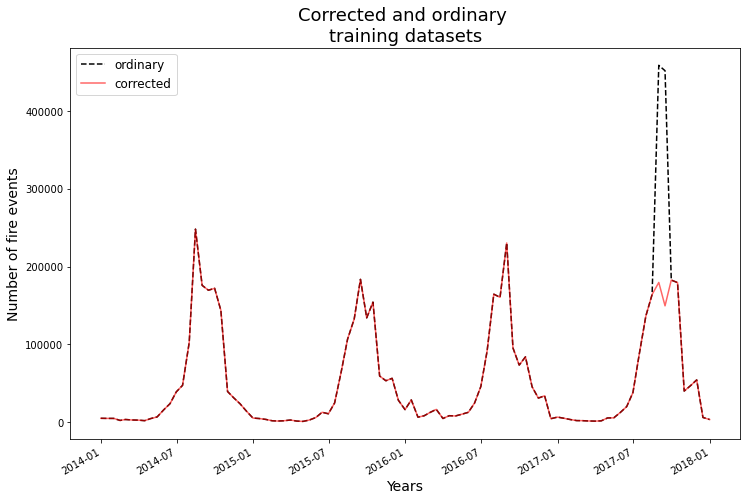

In [154]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(y_train, linestyle = '--', color = 'k', label = 'ordinary')
ax.plot(y_train_ac, color = 'red', label = 'corrected', alpha = 0.6)

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_title('Corrected and ordinary \ntraining datasets', fontsize = 18)

plt.gcf().autofmt_xdate()
plt.legend(fontsize = 12)

plt.show()

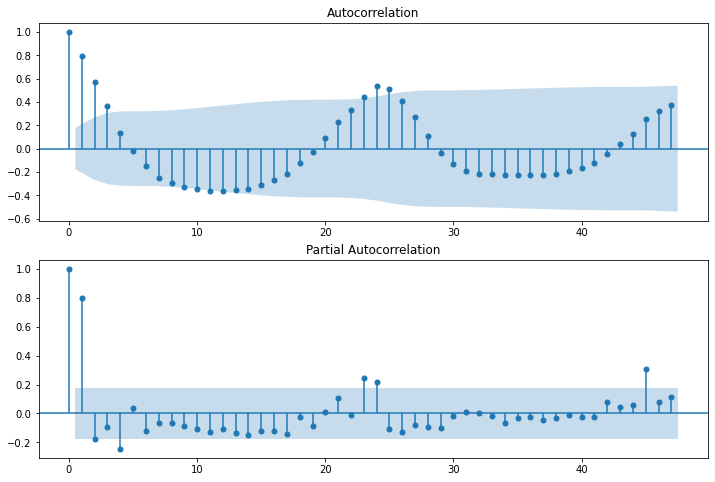

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax1)
plot_pacf(df_all_ac.riscofogo.dropna(),lags=47,ax=ax2)

plt.show()

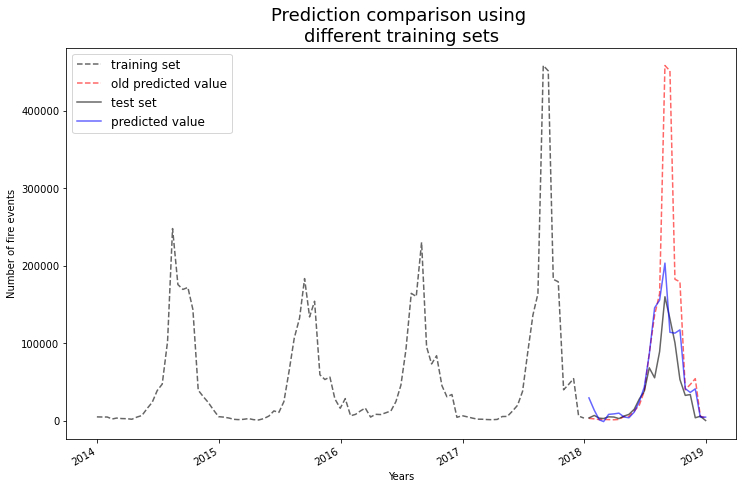

30100.156413692228
35812.791666666664


In [164]:
sarima_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = ((1, 1, 0, 1), 0, 3),
                                         seasonal_order = (2, 0, 0, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res_ac = sarima_model_ac.fit()
forecast_ac = res_ac.get_forecast(len(y_test))


fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(forecast.predicted_mean, label = 'old predicted value', color = 'red', alpha = 0.6, linestyle = '--')
ax.plot(y_test.riscofogo, label = 'test set', color = 'k', alpha = 0.6)

ax.plot(forecast_ac.predicted_mean, label = 'predicted value', color = 'blue', alpha = 0.6)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()


rmse = np.sqrt(mean_squared_error(forecast_ac.predicted_mean, y_test))


print(rmse)
print(y_test.riscofogo.mean())

In [145]:
## Investigating different models

df_all_ac = pd.concat([y_train_ac, y_test])

model_dict = dict()

for order in pdq:
    for seasonal_order in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(df_all_ac, order = order,
                                            seasonal_order = seasonal_order,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        res = sarimax.fit()
        forecast = res.get_forecast(len(y_test))
        
        print (order, seasonal_order, res.aic)
        

(1, 0, 1) (0, 0, 0, 24) 2822.3832936973795
(1, 0, 1) (0, 0, 1, 24) 2234.337556346009
(1, 0, 1) (0, 1, 0, 24) 2254.2507515875764
(1, 0, 1) (0, 1, 1, 24) 2277.6475139607255
(1, 0, 1) (1, 0, 0, 24) 2252.3816454682237
(1, 0, 1) (1, 0, 1, 24) 2223.548129834883
(1, 0, 1) (1, 1, 0, 24) 1694.1494887157905


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 1) (1, 1, 1, 24) 1672.1995705368242
(1, 0, 1) (2, 0, 0, 24) 1690.6212886302847
(1, 0, 1) (2, 0, 1, 24) 1689.0248989994016
(1, 0, 1) (2, 1, 0, 24) 1115.4215636165077
(1, 0, 1) (2, 1, 1, 24) 1382.1172441609608
(1, 0, 1) (3, 0, 0, 24) 1116.4908012844523
(1, 0, 1) (3, 0, 1, 24) 1115.0474123195245
(1, 0, 1) (3, 1, 0, 24) 564.0908897727081


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 1) (3, 1, 1, 24) 634.6665074583226
(1, 0, 2) (0, 0, 0, 24) 2800.8503944301065
(1, 0, 2) (0, 0, 1, 24) 2214.0907637840696
(1, 0, 2) (0, 1, 0, 24) 2233.5790896634094
(1, 0, 2) (0, 1, 1, 24) 2480.415995176821
(1, 0, 2) (1, 0, 0, 24) 2255.195745912762
(1, 0, 2) (1, 0, 1, 24) 2203.8381999581748
(1, 0, 2) (1, 1, 0, 24) 1697.0363290922799


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) (1, 1, 1, 24) 2056.1952998031365
(1, 0, 2) (2, 0, 0, 24) 1693.2866860121994
(1, 0, 2) (2, 0, 1, 24) 1691.794724058081
(1, 0, 2) (2, 1, 0, 24) 1118.404870856637
(1, 0, 2) (2, 1, 1, 24) 1386.05890578855
(1, 0, 2) (3, 0, 0, 24) 1118.9059582586685
(1, 0, 2) (3, 0, 1, 24) 1117.0384283735705
(1, 0, 2) (3, 1, 0, 24) 566.7229693319252


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) (3, 1, 1, 24) 668.1281973921582
(1, 0, 3) (0, 0, 0, 24) 2772.566968575266
(1, 0, 3) (0, 0, 1, 24) 2191.5161543206837
(1, 0, 3) (0, 1, 0, 24) 2213.1011917163046
(1, 0, 3) (0, 1, 1, 24) 2458.1908142620964
(1, 0, 3) (1, 0, 0, 24) 2256.03184027886
(1, 0, 3) (1, 0, 1, 24) 2181.922181636257
(1, 0, 3) (1, 1, 0, 24) 1699.9414692738992


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (1, 1, 1, 24) 2380.5552455300303
(1, 0, 3) (2, 0, 0, 24) 1694.43085978981
(1, 0, 3) (2, 0, 1, 24) 1692.8396299814249
(1, 0, 3) (2, 1, 0, 24) 1120.6043174558604


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (2, 1, 1, 24) 1390.0770813528889
(1, 0, 3) (3, 0, 0, 24) 1117.9912431474997
(1, 0, 3) (3, 0, 1, 24) 1117.767841226572
(1, 0, 3) (3, 1, 0, 24) 569.2136487595423


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) (3, 1, 1, 24) 649.4470596106034
(1, 1, 1) (0, 0, 0, 24) 2805.8514543379715
(1, 1, 1) (0, 0, 1, 24) 2210.97787289245
(1, 1, 1) (0, 1, 0, 24) 2232.410264197745


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1) (0, 1, 1, 24) 2546.726171714657
(1, 1, 1) (1, 0, 0, 24) 2229.1372371500665
(1, 1, 1) (1, 0, 1, 24) 2203.4586385257417
(1, 1, 1) (1, 1, 0, 24) 1677.3669068933923


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1) (1, 1, 1, 24) 3312.7792964802643
(1, 1, 1) (2, 0, 0, 24) 1669.7570649236905
(1, 1, 1) (2, 0, 1, 24) 1670.6181731092151
(1, 1, 1) (2, 1, 0, 24) 1097.2482571635617
(1, 1, 1) (2, 1, 1, 24) 1862.6123134700001
(1, 1, 1) (3, 0, 0, 24) 1095.5345407385557
(1, 1, 1) (3, 0, 1, 24) 1095.412627263688
(1, 1, 1) (3, 1, 0, 24) 543.4579165113375
(1, 1, 1) (3, 1, 1, 24) 1940.6158745027187
(1, 1, 2) (0, 0, 0, 24) 2784.1415834825902
(1, 1, 2) (0, 0, 1, 24) 2197.6829404063874
(1, 1, 2) (0, 1, 0, 24) 2212.3332796499126
(1, 1, 2) (0, 1, 1, 24) 2822.5364874648976
(1, 1, 2) (1, 0, 0, 24) 2232.7962306879576
(1, 1, 2) (1, 0, 1, 24) 2183.870782141509
(1, 1, 2) (1, 1, 0, 24) 1680.1246717309684


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) (1, 1, 1, 24) 2597.9958032377262
(1, 1, 2) (2, 0, 0, 24) 1672.8961800904638
(1, 1, 2) (2, 0, 1, 24) 1672.3528122743103
(1, 1, 2) (2, 1, 0, 24) 1099.6026564059898


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) (2, 1, 1, 24) 1650.7363625761573
(1, 1, 2) (3, 0, 0, 24) 1097.785045474427
(1, 1, 2) (3, 0, 1, 24) 1098.1019980351423
(1, 1, 2) (3, 1, 0, 24) 545.9245157264329
(1, 1, 2) (3, 1, 1, 24) 1943.6327394957293
(1, 1, 3) (0, 0, 0, 24) 2759.7783545453235
(1, 1, 3) (0, 0, 1, 24) 2170.1147514631157
(1, 1, 3) (0, 1, 0, 24) 2197.201166901436
(1, 1, 3) (0, 1, 1, 24) 2783.7750890432317
(1, 1, 3) (1, 0, 0, 24) 2234.4526602909564
(1, 1, 3) (1, 0, 1, 24) 2162.6324030038504
(1, 1, 3) (1, 1, 0, 24) 1682.2426830993643


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) (1, 1, 1, 24) 2395.652365980844
(1, 1, 3) (2, 0, 0, 24) 1674.2925464298319
(1, 1, 3) (2, 0, 1, 24) 1674.1445530109277
(1, 1, 3) (2, 1, 0, 24) 1101.5825480845415


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) (2, 1, 1, 24) 1850.3351655410102
(1, 1, 3) (3, 0, 0, 24) 1099.1215404993702
(1, 1, 3) (3, 0, 1, 24) 1099.1785691584355
(1, 1, 3) (3, 1, 0, 24) 547.9131710356404
(1, 1, 3) (3, 1, 1, 24) 1945.754106531974
(2, 0, 1) (0, 0, 0, 24) 2821.207557263104
(2, 0, 1) (0, 0, 1, 24) 2234.040866457227
(2, 0, 1) (0, 1, 0, 24) 2262.043041302033


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (0, 1, 1, 24) 2285.188033853436
(2, 0, 1) (1, 0, 0, 24) 2229.1335357925923
(2, 0, 1) (1, 0, 1, 24) 2223.843471240219
(2, 0, 1) (1, 1, 0, 24) 1673.534114224407


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (1, 1, 1, 24) 2261.242246021949
(2, 0, 1) (2, 0, 0, 24) 1668.8128691650238
(2, 0, 1) (2, 0, 1, 24) 1667.5089388129186
(2, 0, 1) (2, 1, 0, 24) 1094.5141752973589


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (2, 1, 1, 24) 1526.342615218207
(2, 0, 1) (3, 0, 0, 24) 1095.117187866228


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (3, 0, 1, 24) 1093.4517556689211


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (3, 1, 0, 24) 545.9677283823407


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (3, 1, 1, 24) 719.519480973028
(2, 0, 2) (0, 0, 0, 24) 2797.4171738943146
(2, 0, 2) (0, 0, 1, 24) 2214.2652551087026
(2, 0, 2) (0, 1, 0, 24) 2233.6129209427863


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (0, 1, 1, 24) 2254.5002968423482
(2, 0, 2) (1, 0, 0, 24) 2233.329963119612
(2, 0, 2) (1, 0, 1, 24) 2202.7529865612787
(2, 0, 2) (1, 1, 0, 24) 1675.7798694752694


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (1, 1, 1, 24) 2484.307238866346
(2, 0, 2) (2, 0, 0, 24) 1670.6572077424028


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (2, 0, 1, 24) 1668.818341546519
(2, 0, 2) (2, 1, 0, 24) 1096.6776109346338


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (2, 1, 1, 24) 1384.2810940695276
(2, 0, 2) (3, 0, 0, 24) 1096.7667608459267


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (3, 0, 1, 24) 1095.2772026116702
(2, 0, 2) (3, 1, 0, 24) 545.5585327781869


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (3, 1, 1, 24) 644.0967290202045
(2, 0, 3) (0, 0, 0, 24) 2772.7667262182076
(2, 0, 3) (0, 0, 1, 24) 2192.764289541511
(2, 0, 3) (0, 1, 0, 24) 2214.497533688645


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (0, 1, 1, 24) 2231.6048090513987
(2, 0, 3) (1, 0, 0, 24) 2234.719626161863


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (1, 0, 1, 24) 2181.645620335785
(2, 0, 3) (1, 1, 0, 24) 1678.7222313266323


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (1, 1, 1, 24) 2390.1513678029805
(2, 0, 3) (2, 0, 0, 24) 1673.286852123111


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (2, 0, 1, 24) 1670.4948682892211
(2, 0, 3) (2, 1, 0, 24) 1099.2924309956038


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (2, 1, 1, 24) 1355.5299323003865
(2, 0, 3) (3, 0, 0, 24) 1096.4008725374117
(2, 0, 3) (3, 0, 1, 24) 1097.098298134649
(2, 0, 3) (3, 1, 0, 24) 547.7781613978149


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3) (3, 1, 1, 24) 631.3057422424539
(2, 1, 1) (0, 0, 0, 24) 2799.076282013228
(2, 1, 1) (0, 0, 1, 24) 2212.8050946269013
(2, 1, 1) (0, 1, 0, 24) 2234.397795126398


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1) (0, 1, 1, 24) 2196.170834259096
(2, 1, 1) (1, 0, 0, 24) 2208.3429429483717
(2, 1, 1) (1, 0, 1, 24) 2204.7354282554415
(2, 1, 1) (1, 1, 0, 24) 1655.7819769437774


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1) (1, 1, 1, 24) 3165.724235470058
(2, 1, 1) (2, 0, 0, 24) 1648.1822282289552
(2, 1, 1) (2, 0, 1, 24) 1647.7168665723298
(2, 1, 1) (2, 1, 0, 24) 1075.496580364027


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1) (2, 1, 1, 24) 2043.255754849062
(2, 1, 1) (3, 0, 0, 24) 1073.621287101882
(2, 1, 1) (3, 0, 1, 24) 1073.5570455816849
(2, 1, 1) (3, 1, 0, 24) 522.5440032808635
(2, 1, 1) (3, 1, 1, 24) 1858.8298707334397
(2, 1, 2) (0, 0, 0, 24) 2778.6490777235003
(2, 1, 2) (0, 0, 1, 24) 2196.629935155596
(2, 1, 2) (0, 1, 0, 24) 2211.7599186241277


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) (0, 1, 1, 24) 2979.667849435431
(2, 1, 2) (1, 0, 0, 24) 2210.986968643488
(2, 1, 2) (1, 0, 1, 24) 2185.037948855698
(2, 1, 2) (1, 1, 0, 24) 1656.0790033436858


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) (1, 1, 1, 24) 2743.7841408306363
(2, 1, 2) (2, 0, 0, 24) 1650.4294240350087
(2, 1, 2) (2, 0, 1, 24) 1650.6345142024165
(2, 1, 2) (2, 1, 0, 24) 1078.2056413011874
(2, 1, 2) (2, 1, 1, 24) 1827.2375841636872
(2, 1, 2) (3, 0, 0, 24) 1076.4549206845695
(2, 1, 2) (3, 0, 1, 24) 1076.4880861256852
(2, 1, 2) (3, 1, 0, 24) 523.9331346861308
(2, 1, 2) (3, 1, 1, 24) 1861.6457122078452
(2, 1, 3) (0, 0, 0, 24) 2756.999506212105
(2, 1, 3) (0, 0, 1, 24) 2176.050249862981
(2, 1, 3) (0, 1, 0, 24) 2191.0716190342328


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (0, 1, 1, 24) 1679.3474519277645
(2, 1, 3) (1, 0, 0, 24) 2213.4967266234326


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (1, 0, 1, 24) 2163.758848636719
(2, 1, 3) (1, 1, 0, 24) 1660.7039438957047
(2, 1, 3) (1, 1, 1, 24) 2762.5953784675407
(2, 1, 3) (2, 0, 0, 24) 1652.3618728776687
(2, 1, 3) (2, 0, 1, 24) 1652.6459032290893
(2, 1, 3) (2, 1, 0, 24) 1080.6074186715716


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3) (2, 1, 1, 24) 1769.7604887237624
(2, 1, 3) (3, 0, 0, 24) 1077.9404402095352
(2, 1, 3) (3, 0, 1, 24) 1078.219403398273
(2, 1, 3) (3, 1, 0, 24) 525.9149296348023
(2, 1, 3) (3, 1, 1, 24) 1863.9353103492406
(3, 0, 1) (0, 0, 0, 24) 2798.743414365993
(3, 0, 1) (0, 0, 1, 24) 2236.9045879067367
(3, 0, 1) (0, 1, 0, 24) 2235.3842255759587


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (0, 1, 1, 24) 2281.969937395998
(3, 0, 1) (1, 0, 0, 24) 2210.4979098524987
(3, 0, 1) (1, 0, 1, 24) 2204.203860236105
(3, 0, 1) (1, 1, 0, 24) 1652.2473116282383


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (1, 1, 1, 24) 2317.308747572002
(3, 0, 1) (2, 0, 0, 24) 1647.4735348257063


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (2, 0, 1, 24) 1645.8561224951466
(3, 0, 1) (2, 1, 0, 24) 1072.989461740553


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (2, 1, 1, 24) 1330.3683093337856
(3, 0, 1) (3, 0, 0, 24) 1073.232631676854
(3, 0, 1) (3, 0, 1, 24) 1072.2436317423374
(3, 0, 1) (3, 1, 0, 24) 521.0957718777979


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1) (3, 1, 1, 24) 592.9289119123788
(3, 0, 2) (0, 0, 0, 24) 2796.7209285275867
(3, 0, 2) (0, 0, 1, 24) 2215.6885760517216
(3, 0, 2) (0, 1, 0, 24) 2256.756232625194


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (0, 1, 1, 24) 2247.816449338825
(3, 0, 2) (1, 0, 0, 24) 2212.1710929136893


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (1, 0, 1, 24) 2202.4333606860355
(3, 0, 2) (1, 1, 0, 24) 1651.692847292792


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (1, 1, 1, 24) 2436.467882665058


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 0, 0, 24) 1649.6230307400913


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 0, 1, 24) 1647.6840822071922
(3, 0, 2) (2, 1, 0, 24) 1075.3608792024713


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (2, 1, 1, 24) 1454.314730617922
(3, 0, 2) (3, 0, 0, 24) 1074.6659272823058


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (3, 0, 1, 24) 1074.5338358422896
(3, 0, 2) (3, 1, 0, 24) 524.7004984821549


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2) (3, 1, 1, 24) 587.9355177109628
(3, 0, 3) (0, 0, 0, 24) 2774.684925803118
(3, 0, 3) (0, 0, 1, 24) 2194.759547920371
(3, 0, 3) (0, 1, 0, 24) 2207.1319038708734


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (0, 1, 1, 24) 2271.5271199903614
(3, 0, 3) (1, 0, 0, 24) 2213.9655865799937


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (1, 0, 1, 24) 2183.805779616208


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (1, 1, 0, 24) 1656.1010969514566


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (1, 1, 1, 24) 2403.3876638090046
(3, 0, 3) (2, 0, 0, 24) 1652.5072363132
(3, 0, 3) (2, 0, 1, 24) 1649.7748283899307
(3, 0, 3) (2, 1, 0, 24) 1078.3478609682409


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (2, 1, 1, 24) 1329.7439221995733
(3, 0, 3) (3, 0, 0, 24) 1075.6390746000843


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (3, 0, 1, 24) 1075.1670182242453
(3, 0, 3) (3, 1, 0, 24) 525.8517328465434


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3) (3, 1, 1, 24) 604.3623099198284
(3, 1, 1) (0, 0, 0, 24) 2784.487968822156
(3, 1, 1) (0, 0, 1, 24) 2221.1081574517248
(3, 1, 1) (0, 1, 0, 24) 2213.5522823601805


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1) (0, 1, 1, 24) 2734.2832448485915
(3, 1, 1) (1, 0, 0, 24) 2187.5161021433955
(3, 1, 1) (1, 0, 1, 24) 2183.865667911121
(3, 1, 1) (1, 1, 0, 24) 1634.824069665446
(3, 1, 1) (1, 1, 1, 24) 2843.4443894217625
(3, 1, 1) (2, 0, 0, 24) 1627.402098648601
(3, 1, 1) (2, 0, 1, 24) 1626.6705033420026
(3, 1, 1) (2, 1, 0, 24) 1054.647836558533


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1) (2, 1, 1, 24) 2089.0890548079287
(3, 1, 1) (3, 0, 0, 24) 1052.8925110219238
(3, 1, 1) (3, 0, 1, 24) 1052.6847464974662
(3, 1, 1) (3, 1, 0, 24) 500.67997627599215
(3, 1, 1) (3, 1, 1, 24) 1777.0648766091924
(3, 1, 2) (0, 0, 0, 24) 2779.636030081593
(3, 1, 2) (0, 0, 1, 24) 2195.6822628338273
(3, 1, 2) (0, 1, 0, 24) 2224.7508831709733
(3, 1, 2) (0, 1, 1, 24) 788.4947660006487


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (1, 0, 0, 24) 2191.8407496306263
(3, 1, 2) (1, 0, 1, 24) 2186.3313441962428
(3, 1, 2) (1, 1, 0, 24) 1634.6127422423938


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (1, 1, 1, 24) 791.3100097475022
(3, 1, 2) (2, 0, 0, 24) 1633.8505839690276
(3, 1, 2) (2, 0, 1, 24) 1629.958501109377
(3, 1, 2) (2, 1, 0, 24) 1056.6440988488127


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (2, 1, 1, 24) 18.0
(3, 1, 2) (3, 0, 0, 24) 1054.8383087259774
(3, 1, 2) (3, 0, 1, 24) 1054.7664540000217
(3, 1, 2) (3, 1, 0, 24) 502.7283203215906


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) (3, 1, 1, 24) 20.0
(3, 1, 3) (0, 0, 0, 24) 2758.6251819388845


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (0, 0, 1, 24) 2166.8542873878964
(3, 1, 3) (0, 1, 0, 24) 2195.0280321382425


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (0, 1, 1, 24) 2746.1401637045437
(3, 1, 3) (1, 0, 0, 24) 2187.3616578822785
(3, 1, 3) (1, 0, 1, 24) 2165.458186253337
(3, 1, 3) (1, 1, 0, 24) 1639.6179758678893


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (1, 1, 1, 24) 2998.095660533338


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (2, 0, 0, 24) 1629.03677335925


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (2, 0, 1, 24) 1631.461717786484
(3, 1, 3) (2, 1, 0, 24) 1059.5013870909115


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (2, 1, 1, 24) 1663.309887634615
(3, 1, 3) (3, 0, 0, 24) 1056.7642712186039


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) (3, 0, 1, 24) 1057.4307985929963
(3, 1, 3) (3, 1, 0, 24) 504.96077373084984
(3, 1, 3) (3, 1, 1, 24) 1782.0280101425085
(4, 0, 1) (0, 0, 0, 24) 2774.591479351145
(4, 0, 1) (0, 0, 1, 24) 2237.275836557931
(4, 0, 1) (0, 1, 0, 24) 2213.9012115465516


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1) (0, 1, 1, 24) 2284.182738120893
(4, 0, 1) (1, 0, 0, 24) 2188.454046260107
(4, 0, 1) (1, 0, 1, 24) 2180.277839108284
(4, 0, 1) (1, 1, 0, 24) 1631.5718922743515


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1) (1, 1, 1, 24) 2216.657365151992
(4, 0, 1) (2, 0, 0, 24) 1626.780580128005
(4, 0, 1) (2, 0, 1, 24) 1623.967128000526
(4, 0, 1) (2, 1, 0, 24) 1052.3000470002582


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1) (2, 1, 1, 24) 1303.7788342825584
(4, 0, 1) (3, 0, 0, 24) 1051.2154976105214
(4, 0, 1) (3, 0, 1, 24) 1049.3296945705508
(4, 0, 1) (3, 1, 0, 24) 499.38181270945114


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1) (3, 1, 1, 24) 568.093430644251
(4, 0, 2) (0, 0, 0, 24) 2774.3387271868796
(4, 0, 2) (0, 0, 1, 24) 2216.759656152476
(4, 0, 2) (0, 1, 0, 24) 2214.608167473446


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (0, 1, 1, 24) 2256.254617062629
(4, 0, 2) (1, 0, 0, 24) 2190.5154157109973


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (1, 0, 1, 24) 2182.6463580759037


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (1, 1, 0, 24) 1631.0155738527976


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (1, 1, 1, 24) 2186.5575745383103
(4, 0, 2) (2, 0, 0, 24) 1629.1957434701712


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (2, 0, 1, 24) 1626.2574604435279
(4, 0, 2) (2, 1, 0, 24) 1054.5074709683356


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (2, 1, 1, 24) 1476.930580906678
(4, 0, 2) (3, 0, 0, 24) 1052.5294113709501


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2) (3, 0, 1, 24) 1052.7605471876582
(4, 0, 2) (3, 1, 0, 24) 502.447431925378
(4, 0, 2) (3, 1, 1, 24) 762.201272154378
(4, 0, 3) (0, 0, 0, 24) 2776.5319516198165
(4, 0, 3) (0, 0, 1, 24) 2196.7303892990813
(4, 0, 3) (0, 1, 0, 24) 2208.192566643421


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (0, 1, 1, 24) 2230.5219812781224


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (1, 0, 0, 24) 2193.2810924468463


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (1, 0, 1, 24) 2181.5857600380245
(4, 0, 3) (1, 1, 0, 24) 1633.8780414838131


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (1, 1, 1, 24) 2470.581546533461


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (2, 0, 0, 24) 1631.7093001098124


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (2, 0, 1, 24) 1629.1870049611973
(4, 0, 3) (2, 1, 0, 24) 1057.2604613521453


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (2, 1, 1, 24) 1309.5807380279334
(4, 0, 3) (3, 0, 0, 24) 1054.7519627760926


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 0, 1, 24) 1054.3204893971692


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 1, 0, 24) 505.01367183645493


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3) (3, 1, 1, 24) 575.5470441254417
(4, 1, 1) (0, 0, 0, 24) 2746.863834344754
(4, 1, 1) (0, 0, 1, 24) 2213.641698495722
(4, 1, 1) (0, 1, 0, 24) 2192.826645939352


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 1) (0, 1, 1, 24) 2846.6242813038607
(4, 1, 1) (1, 0, 0, 24) 2166.1432166092586
(4, 1, 1) (1, 0, 1, 24) 2163.1031454318036
(4, 1, 1) (1, 1, 0, 24) 1614.0750885256184


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 1) (1, 1, 1, 24) 3088.0035697061467
(4, 1, 1) (2, 0, 0, 24) 1606.779174435708
(4, 1, 1) (2, 0, 1, 24) 1605.9947562299012
(4, 1, 1) (2, 1, 0, 24) 1032.7181738158038


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 1) (2, 1, 1, 24) 1647.7303799304068
(4, 1, 1) (3, 0, 0, 24) 1030.4623744267078
(4, 1, 1) (3, 0, 1, 24) 1030.9306601765388
(4, 1, 1) (3, 1, 0, 24) 479.4755705609997
(4, 1, 1) (3, 1, 1, 24) 1695.5088497085897
(4, 1, 2) (0, 0, 0, 24) 2766.800203075252


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (0, 0, 1, 24) 2187.07011238959


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (0, 1, 0, 24) 2193.916230692629


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (0, 1, 1, 24) 6480.50922908311


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (1, 0, 0, 24) 2174.592803854815


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (1, 0, 1, 24) 2168.60462601757


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (1, 1, 0, 24) 1613.1002289237967


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (1, 1, 1, 24) nan


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (2, 0, 0, 24) 1607.1820179463853


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (2, 0, 1, 24) 1605.6415319616995


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (2, 1, 0, 24) 1092.0038908069062


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (2, 1, 1, 24) nan
(4, 1, 2) (3, 0, 0, 24) 1033.3904438019222


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (3, 0, 1, 24) 1032.8804239443261


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (3, 1, 0, 24) 539.4923737230438


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 2) (3, 1, 1, 24) 1847.885292129658
(4, 1, 3) (0, 0, 0, 24) 2748.8858084904655


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (0, 0, 1, 24) 2167.1205893218357
(4, 1, 3) (0, 1, 0, 24) 2196.105036070564
(4, 1, 3) (0, 1, 1, 24) 5878.591219690545


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (1, 0, 0, 24) 2166.1331134840134


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (1, 0, 1, 24) 2161.8599798366863
(4, 1, 3) (1, 1, 0, 24) 1618.1705546256328
(4, 1, 3) (1, 1, 1, 24) 5897.2542525489425


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (2, 0, 0, 24) 1606.8123154709926


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (2, 0, 1, 24) 1608.0624441671087


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (2, 1, 0, 24) 1036.5981930206171


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (2, 1, 1, 24) 195.62207711460647


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (3, 0, 0, 24) 1034.645847767364


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) (3, 0, 1, 24) 1034.0066886922045
(4, 1, 3) (3, 1, 0, 24) 483.71401173499805
(4, 1, 3) (3, 1, 1, 24) 1699.8178518675654


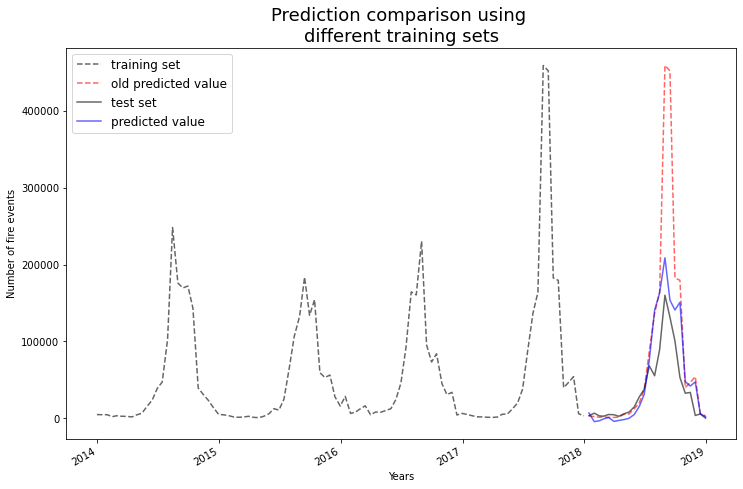

35196.72091723276
35812.791666666664


In [189]:
sarima_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = (2, 1, 3),
                                         seasonal_order =  (3, 0, 1, 24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
res_ac = sarima_model_ac.fit()
forecast_ac = res_ac.get_forecast(len(y_test))


fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(forecast.predicted_mean, label = 'old predicted value', color = 'red', alpha = 0.6, linestyle = '--')
ax.plot(y_test.riscofogo, label = 'test set', color = 'k', alpha = 0.6)

ax.plot(forecast_ac.predicted_mean, label = 'predicted value', color = 'blue', alpha = 0.6)

ax.set_title('Prediction comparison using \ndifferent training sets', fontsize = 18)
ax.set_xlabel('Years')
ax.set_ylabel('Number of fire events')

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()


rmse = np.sqrt(mean_squared_error(forecast_ac.predicted_mean, y_test))


print(rmse)
print(y_test.riscofogo.mean())

In [191]:
rmse_ac = np.sqrt(mean_squared_error(forecast_ac.predicted_mean, y_test))
rmse = np.sqrt(mean_squared_error(forecast.predicted_mean, y_test))

print(rmse)
print(rmse_ac)
print(y_test.riscofogo.mean())

97873.0437750803
35196.72091723276
35812.791666666664
